In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import bioread as br
import dtw

import matplotlib.pyplot as plt
import scipy.signal as signal
import sklearn
import os
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from scipy.stats import spearmanr

In [2]:
print('bioread, v.', br.__version__)
print('numpy, v.', np.__version__)
print('dtw, v.', dtw.__version__)
print('sklearn, v.', sklearn.__version__)

bioread, v. 1.0.4
numpy, v. 1.19.0
dtw, v. 1.4.0
sklearn, v. 0.23.1


In [3]:
#sns.crayons

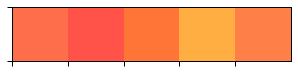

In [4]:
sns.set_context('paper')

pal = sns.crayon_palette(['Outrageous Orange', 'Red Orange', 'Orange', 'Yellow Orange', 'Burnt Orange'])
sns.set_palette(pal)
sns.palplot(pal)

In [5]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

In [6]:
data_fname = '/Users/kbottenh/Dropbox/Projects/physio/mbme-physio-denoising/example_data/4232_1_Musser_K23_redux.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/kbottenh/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))
    
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Digital' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel

timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

#from DIVA
#slices = 48
#tr = 1.5
#mb = 3

slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = data.samples_per_second

nyquist = fs/2
Q = 100

In [7]:
fft_ecg_nomri = signal.decimate(np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000]), 10)
freq_ecg_nomri = signal.decimate(np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], d=0.0005), 10)

limit = np.where(freq_ecg_nomri >= 60)[0][0]

In [8]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(i, np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 5.588508333333333, 1: 5.595275, 2: 5.592233333333334, 3: 5.602908333333334, 4: 5.001625000000001, 5: 5.0017}


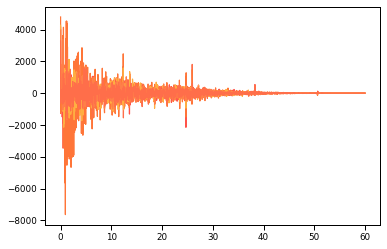

In [9]:
fft_ecg = {}
freq = {}
ecg = {}
for scan in scans.keys():
    ecg[scan] = timeseries[timeseries.index.isin(scan_idx[scan])]['ECG']
    fft_ecg[scan] = signal.decimate(np.fft.fft(ecg[scan]), 10)
    freq[scan] = signal.decimate(np.fft.fftfreq(ecg[scan].shape[-1], d=0.0005), 10)
    limit = np.where(freq[scan].real >= 60)[0][0]
    sns.lineplot(freq[scan][:limit], fft_ecg[scan].real[:limit])

In [10]:
np.where(freq[scan].real >= 60)[0][0]

1822

In [11]:
steps_in_denoising = ['raw', 'BIOPAC', 'MB-BIOPAC', 'Bottenhorn']

In [12]:
index = pd.MultiIndex.from_product([scans.keys(), steps_in_denoising], names=['scan', 'step'])

In [ ]:
#msc = {}
dist = pd.DataFrame(index=index, columns=index, dtype=float)
for scan1 in scans.keys():
    fft1 = fft_ecg[scan1].real
    corr = np.corrcoef(abs(fft1[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
    dist.at[(scan1, 'raw'), 'noMR'] = corr
    
    notch = slices / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpfilt1 = signal.decimate(np.fft.fft(filtered),10)
    corr = np.corrcoef(abs(fft_bpfilt1[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
    dist.at[(scan1, 'BIOPAC'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft1[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'BIOPAC')] = corr
    dist.at[(scan1, 'BIOPAC'), (scan1, 'raw')] = corr
    
    notch = slices / mb / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpmbfilt1 = signal.decimate(np.fft.fft(filtered), 10)
    corr = np.corrcoef(abs(fft_bpmbfilt1[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft1[:18007]), abs(fft_bpmbfilt1[:18007]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bpmbfilt1[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
    
    notches = {'slices': slices / mb / tr, 
               'tr': 1 / tr}
    filtered1 = ecg[scan1]
    for notch in notches:
        filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)
    
    fft_bottfilt1 = signal.decimate(np.fft.fft(filtered1), 10)
    corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft1[:18007]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_bpmbfilt1[:18007]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr

    for scan2 in scans.keys():
        fft2 = fft_ecg[scan2].real
        corr =  np.corrcoef(abs(fft1[:18007]), abs(fft2[:18007]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'raw')] = corr
        dist.at[(scan1, 'raw'), (scan2, 'raw')] = corr
        corr = np.corrcoef(abs(fft2[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
        dist.at[(scan2, 'raw'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft2[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:18007]), abs(fft_bpmbfilt1[:18007]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:18007]), abs(fft_bottfilt1[:18007]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'Bottenhorn')] = corr

        notch = slices / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpfilt2 = signal.decimate(np.fft.fft(filtered),10)
        corr = np.corrcoef(abs(fft_bpfilt2[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft1[:18007]), abs(fft_bpfilt2[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpfilt2[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:18007]), abs(fft_bpfilt2[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_bpfilt2[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
        #corr = np.corrcoef(abs(fft1[:18007]), abs(fft_bpfilt2[:18007]))[0][1]
        #dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr

        notch = slices / mb / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpmbfilt2 = signal.decimate(np.fft.fft(filtered), 10)
        corr = np.corrcoef(abs(fft_bpmbfilt2[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:18007]), abs(fft1[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:18007]), abs(fft_bpmbfilt2[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_bpmbfilt2[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
        
        filtered1 = ecg[scan2]
        for notch in notches:
            filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

        fft_bottfilt2 = signal.decimate(np.fft.fft(filtered1),10)
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_ecg_nomri[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft1[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpmbfilt1[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:18007]), abs(fft_bottfilt2[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'Bottenhorn')] = corr

        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft2[:18007]))[0][1]
        dist.at[(scan2, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft1[:18007]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpfilt2[:18007]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpmbfilt2[:18007]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr
        
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft1[:18007]))[0][1]
        dist.at[(scan1, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpfilt1[:18007]))[0][1]
        dist.at[(scan1, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:18007]), abs(fft_bpmbfilt1[:18007]))[0][1]
        dist.at[(scan1, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dist, square=True, vmin=0, cmap='viridis', )
fig.savefig(os.path.join(out_dir, 'figures', 'fft_correlations-{0}.png'.format(basename)), dpi=300)

In [ ]:
dist.sort_values('noMR', axis=0, ascending=False)

In [ ]:
dist.to_csv(os.path.join(out_dir, 'fft_correlations-ECG-{0}.csv'.format(basename)))